### 01c – Patient-Source Explorer

**Input**: `df` from `01b_setup.ipynb` – cleaned, 23 columns, ~4 million rows  
**Purpose**: Understand workload drivers by **patient_source**  
**Outputs**: Tables, charts, heat-maps for Emergency / Elective baselines

> **Columns in focus**  
> • `patient_source` – e.g. “Admitted Patient Care – Inpatient …”, “GP Direct Access”, “Outpatient …”  
> • `modality`, `sub_modality`, `anatomy_group`, `age_band`, `sex`, `financial_year`, `activity_month`


In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import os, re, glob, warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)

1 – Load the seven CSVs & clean to 23 columns

In [2]:
# ----------- 1A. Point to your raw folder OR hard-code the list ----------
raw_dir   = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"   
csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))

if not csv_files:
    raise FileNotFoundError("csv_files list is empty – check raw_dir or paths")

print(f"Detected {len(csv_files)} files")

Detected 7 files


In [3]:
# ----------- canonical 23-column schema from the SQL query ---------------
expected_cols = [
    'icb_code','icb_name','lsoa_code','nhs_region',
    'site_code','site_name','provider_code','provider_name',
    'activity_month','financial_year','financial_month','test_date',
    'age','sex','modality','sub_modality','procedure_name',
    'referral_type','patient_source','cancer_flag','subcancer_flag',
    'referring_org_code','referring_org_name'
]

dfs, meta = [], []
for fp in csv_files:
    peek = pd.read_csv(fp, nrows=5)
    if not set(expected_cols).issubset(peek.columns):
        print(f" {os.path.basename(fp)} – no header found, re-loading with names")
        df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
    else:
        df_tmp = pd.read_csv(fp, low_memory=False)

    df_tmp = df_tmp.dropna(axis=1, how='all')
    df_tmp.columns = df_tmp.columns.str.strip().str.lower()
    df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
    for col in (set(expected_cols) - set(df_tmp.columns)):
        df_tmp[col] = pd.NA
    df_tmp = df_tmp[expected_cols]
    dfs.append(df_tmp)

    meta.append({
        "file": os.path.basename(fp),
        "rows": len(df_tmp),
        "cols": df_tmp.shape[1],
        "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
    })

meta_df = pd.DataFrame(meta)
display(meta_df.style.set_caption("Loaded files – rows / cols / size"))

df = pd.concat(dfs, ignore_index=True)
print(f"Combined shape: {df.shape}")          # expect ~4 M × 23

# basic type coercion
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["test_date"] = pd.to_datetime(df["test_date"], errors="coerce")
df["activity_month"] = pd.to_datetime(
    df["activity_month"].astype(str), format="%Y%m", errors="coerce"
)

 2024_NHS_SW_Somerset_ICB_11X.csv – no header found, re-loading with names
 2024_NHS_SW_Cornwall_ICB_11N.csv – no header found, re-loading with names
 2024_NHS_SW_Gloucestershire_ICB_11M.csv – no header found, re-loading with names
 2024_NHS_SW_Dorset_ICB_11J.csv – no header found, re-loading with names
 2024_NHS_SW_Devon_ICB_15N.csv – no header found, re-loading with names
 2024_NHS_SW_BSW_ICB_92G.csv – no header found, re-loading with names
 2024_NHS_SW_BNSSG_ICB_15C.csv – no header found, re-loading with names


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000


Combined shape: (3989252, 23)


2 – Normalise `patient_source` and create coarse buckets

In [4]:
df["patient_source"] = (
    df["patient_source"]
      .astype(str).str.strip().str.lower()
      .str.replace(r"\(this health care provider\)", "", regex=True)
      .str.replace(r"\s+-\s+", " – ", regex=True)
      .replace({"nan": np.nan})
      .fillna("unknown")
)

bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency",
    r"gp direct|gp ":             "GP",
    r"inpatient":                 "Inpatient",
    r"outpatient":                "Outpatient",
    r"elective|planned":          "Elective",
}
def ps_bucket(txt:str) -> str:
    for pat, lab in bucket_map.items():
        if re.search(pat, txt):
            return lab
    return "Other/Unknown"

df["ps_bucket"] = df["patient_source"].apply(ps_bucket)

In [5]:
# freq table
ps_vc = df["patient_source"].value_counts().to_frame("Count")
ps_vc["%"] = (ps_vc["Count"]/len(df)*100).round(2)
display(ps_vc.head(20).style.set_caption("Patient_source (raw strings)"))

bucket_counts = df["ps_bucket"].value_counts().to_frame("Scans")
bucket_counts["%"] = (bucket_counts["Scans"]/len(df)*100).round(2)
display(bucket_counts.style.set_caption("Patient_source buckets"))


,Count,%
patient_source,,
outpatient,1428095,35.800000
gp direct access,923522,23.150000
accident and emergency department,832850,20.880000
admitted patient care – inpatient,695375,17.430000
other,50250,1.260000
admitted patient care – day case,40758,1.020000
other health care provider,18402,0.460000


,Scans,%
ps_bucket,,
Outpatient,1428095,35.800000
GP,923522,23.150000
Emergency,832850,20.880000
Inpatient,695375,17.430000
Other/Unknown,109410,2.740000


3 – Bar plot (top 15 raw strings)

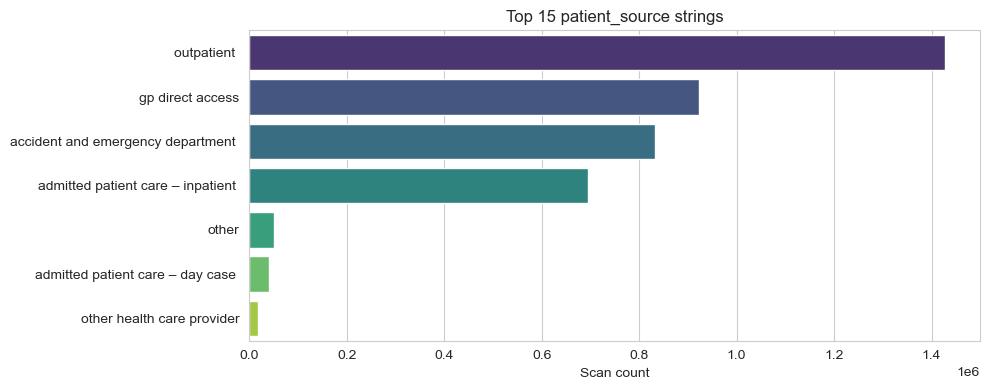

In [6]:
plt.figure(figsize=(10,4))
sns.barplot(
    y=ps_vc.index[:15], x=ps_vc["Count"].head(15),
    palette="viridis"
)
plt.xlabel("Scan count"); plt.ylabel("")
plt.title("Top 15 patient_source strings")
plt.tight_layout(); plt.show()

4 – Age-band prep & profiles

In [7]:
# ONS bands
bands = pd.DataFrame({
    "lower":[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper":[4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label":["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
             "40-44","45-49","50-54","55-59","60-64","65-69","70-74",
             "75-79","80-84","85+"]
})
bins   = bands["lower"].tolist() + [np.inf]
labels = bands["label"]
df = df[df["age"].notna() & (df["age"]%1==0)]  # keep whole ages
df["age"] = df["age"].astype(int)
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels, right=True)

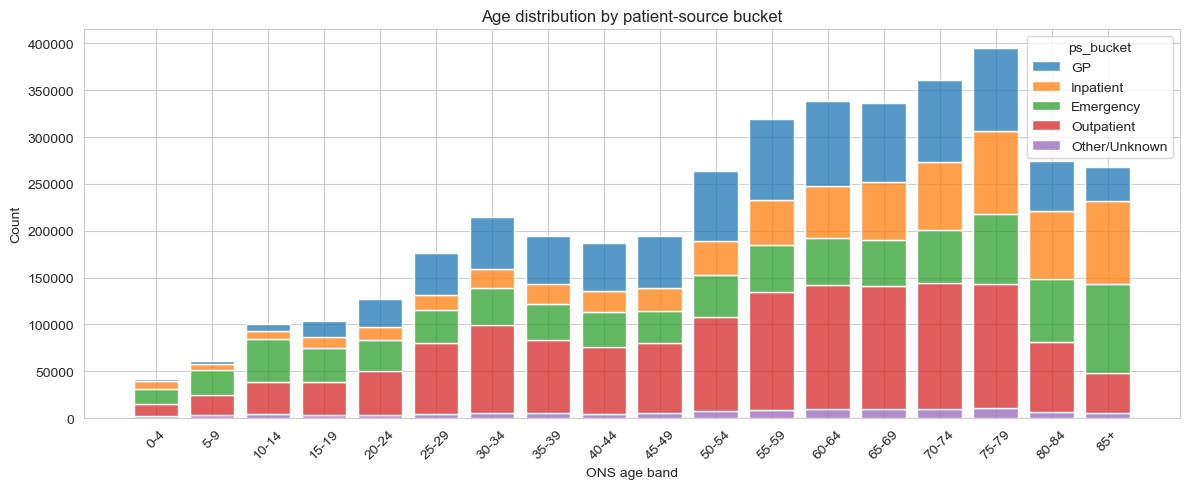

In [8]:
# stacked bar
plt.figure(figsize=(12,5))
sns.histplot(data=df, x="age_band", hue="ps_bucket",
             multiple="stack", shrink=0.8, stat="count")
plt.xticks(rotation=45); plt.xlabel("ONS age band")
plt.title("Age distribution by patient-source bucket")
plt.tight_layout(); plt.show()


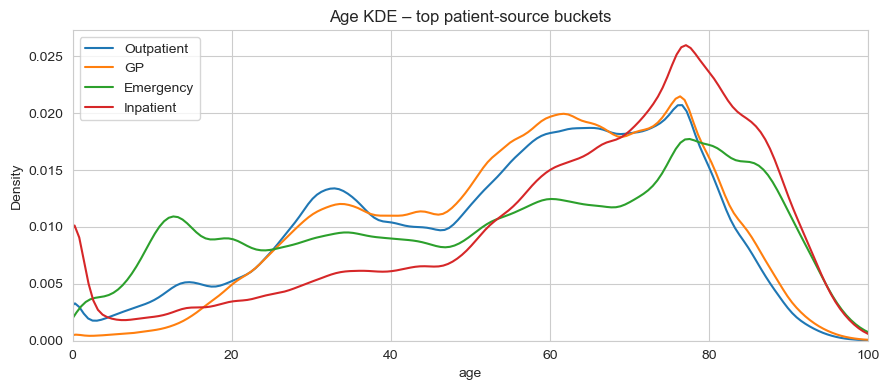

In [9]:
# KDE curves (top 4 buckets)
top_buckets = bucket_counts.index[:4]
plt.figure(figsize=(9,4))
for b in top_buckets:
    sns.kdeplot(data=df[df["ps_bucket"]==b], x="age", label=b, bw_adjust=0.8)
plt.xlim(0,100); plt.title("Age KDE – top patient-source buckets")
plt.legend(); plt.tight_layout(); plt.show()


5 – Modality × patient_source heat-map

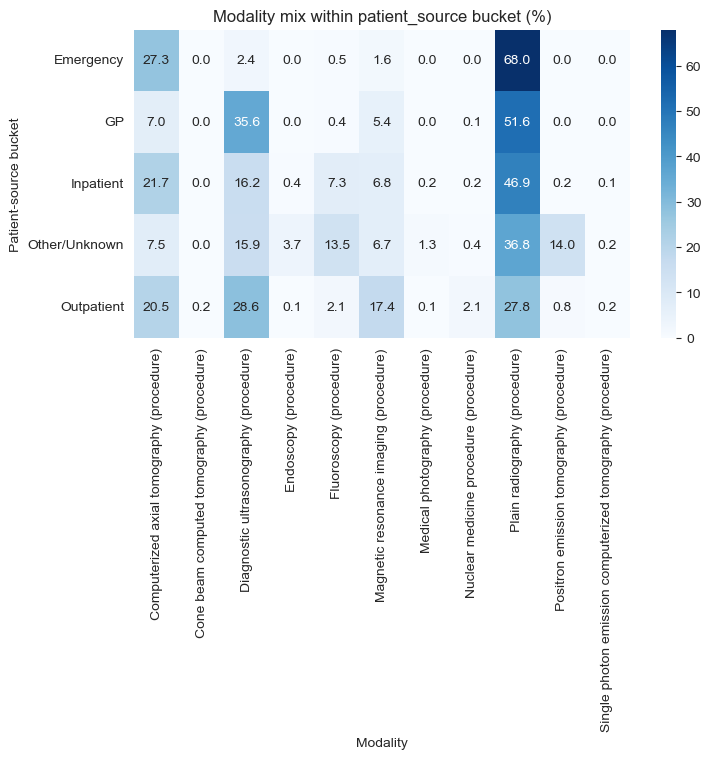

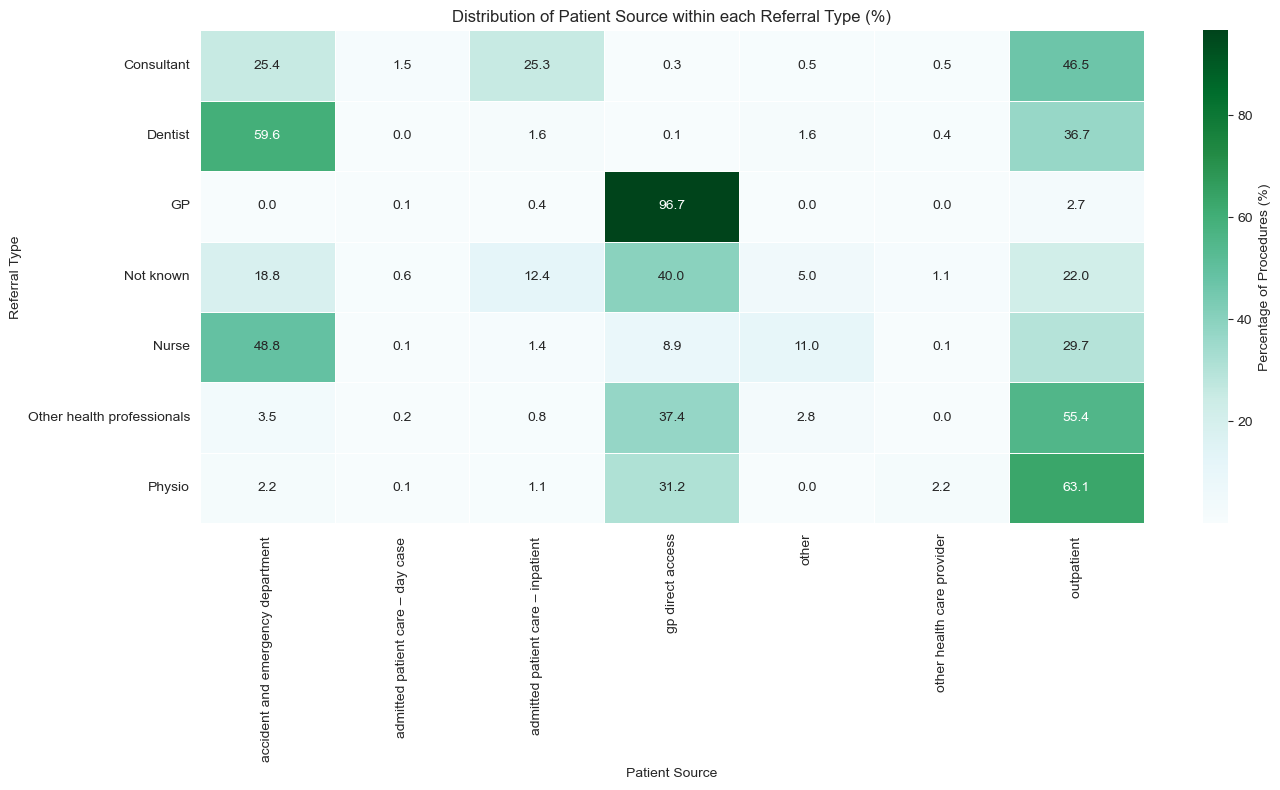

In [14]:
pivot_mod = pd.crosstab(df["ps_bucket"], df["modality"], normalize="index").round(3)
plt.figure(figsize=(8,4))
sns.heatmap(pivot_mod*100, annot=True, fmt=".1f", cmap="Blues")
plt.title("Modality mix within patient_source bucket (%)")
plt.ylabel("Patient-source bucket"); plt.xlabel("Modality")
plt.tight_layout(); plt.show()

# Modality Mix Within (Referral Type × Patient Source)

# Step 1 – Select the relevant columns
pivot_cols = ['referral_type', 'patient_source']
df_temp = df[pivot_cols].copy()
df_temp = df_temp.dropna()

# Step 2 – Create the percentage matrix (crosstab with normalization)
# This will calculate the % distribution of Patient Source for each Referral Type
ref_source_matrix_pct = pd.crosstab(
    index=df_temp['referral_type'],
    columns=df_temp['patient_source'],
    normalize='index'
)

# Step 3 – Plot heatmap of the percentages
plt.figure(figsize=(14, 8))
sns.heatmap(
    ref_source_matrix_pct * 100,  # Multiply by 100 to show as percentages
    cmap='BuGn',
    annot=True,
    fmt=".1f",  # Format as a float with one decimal place
    linewidths=.5,
    cbar_kws={'label': 'Percentage of Procedures (%)'}
)

plt.title("Distribution of Patient Source within each Referral Type (%)")
plt.xlabel("Patient Source")
plt.ylabel("Referral Type")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


6 – (Option) Anatomy × patient_source heat-map

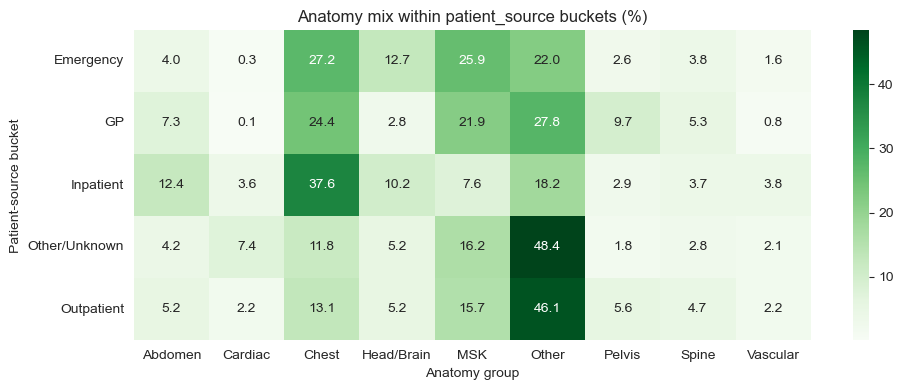

In [11]:
anat_map = {
    r"(head|brain|skull|intracranial|pituitary|orbit)": "Head/Brain",
    r"(spine|sacroiliac)":                              "Spine",
    r"(chest|thorax|pulmonary|lung)":                   "Chest",
    r"(abdomen|liver|pancreas|gallbladder)":            "Abdomen",
    r"(pelvis|prostate|rectum|gynaec|uterus)":          "Pelvis",
    r"(knee|hip|shoulder|ankle|foot|wrist)":            "MSK",
    r"(heart|coronary|cardiac|myocardial)":             "Cardiac",
    r"(aorta|angiography|artery|vein)":                 "Vascular",
}
def map_anat(txt:str)->str:
    for pat,lab in anat_map.items():
        if re.search(pat, txt): return lab
    return "Other"

if "anatomy_group" not in df.columns:
    df["anatomy_group"] = df["procedure_name"].str.lower().apply(map_anat)

pivot_anat = pd.crosstab(df["ps_bucket"], df["anatomy_group"], normalize="index").round(3)
plt.figure(figsize=(10,4))
sns.heatmap(pivot_anat*100, annot=True, fmt=".1f", cmap="Greens")
plt.title("Anatomy mix within patient_source buckets (%)")
plt.ylabel("Patient-source bucket"); plt.xlabel("Anatomy group")
plt.tight_layout(); plt.show()


7 – Monthly trend (3-month MA) by patient_source bucket

In [ ]:
ts = (df
      .groupby([df["activity_month"], "ps_bucket"])
      .size()
      .unstack(fill_value=0)
      .rolling(3, center=True).mean())

ts.plot(figsize=(12,4))
plt.ylabel("Scans"); plt.title("Monthly activity – 3-month moving average")
plt.tight_layout(); plt.show()
